In [1]:
import torchvision.models as models
import torch.nn as nn
import torch
import loaders
import hyperparameters
import training
import matplotlib.pyplot as plt
import numpy as np

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
## setup current model and load weights
resnet50 = models.resnet50()
num_classes = 7
resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)
pretrained = torch.load("./saved_model/resnet50_on_FER.pth")
resnet50.load_state_dict(pretrained["state_dict"])
resnet50.to(device)
resnet50.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [4]:
## make some evaluation on full image (no mask)
full_val_loader = loaders.get_loader(
    mask="full", train=False, shuffle=True
)
# VAL_BATCH_SIZE = 100
# full_val_transform = transforms.Compose(
#     [
#         transforms.ToTensor(),
#         transforms.Normalize(
#             (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
#         )
#     ]
# )
# full_val_set = FacialImageData(
#     directory="./data/test",
#     transform=full_val_transform
# )
# full_val_loader = DataLoader(
#     full_val_set,
#     batch_size=VAL_BATCH_SIZE,
#     shuffle=False,
#     num_workers=2
# )

In [5]:
loss_func = nn.CrossEntropyLoss().to(device)

In [6]:
with torch.no_grad():
    val_loss = 0
    total_examples = 0
    correct_examples = 0
    for batch_idx, (inputs, targets) in enumerate(full_val_loader):
        # copy inputs to device
        inputs = inputs.to(device)
        targets = targets.to(device)
        # compute the output and loss
        out = resnet50(inputs)
        loss = loss_func(out, targets)
        # count the number of correctly predicted samples
        # in the current batch
        _, predicted = torch.max(out, 1)
        correct = predicted.eq(targets).sum()
        val_loss += loss.detach().cpu()
        total_examples += targets.shape[0]
        correct_examples += correct.item()
avg_loss = val_loss / len(full_val_loader)
val2_avg_acc = correct_examples / total_examples
print(
    "Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, val2_avg_acc)
)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation loss: 0.9509, Validation accuracy: 0.6649


In [7]:
## make some evaluation on upper masked image (upper mask)
upper_mask_val_loader = loaders.get_loader(
    mask="upper", train=False, shuffle=True
)
# upper_mask_val_transform = transforms.Compose(
#     [
#         transforms.ToTensor(),
#         ImgMask([1, 2]),
#         transforms.Normalize(
#             (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
#         )
#     ]
# )
# upper_mask_val_set = FacialImageData(
#     directory="./data/test",
#     transform=upper_mask_val_transform
# )
# upper_mask_val_loader = DataLoader(
#     upper_mask_val_set,
#     batch_size=VAL_BATCH_SIZE,
#     shuffle=False,
#     num_workers=2
# )

In [8]:
with torch.no_grad():
    val_loss = 0
    total_examples = 0
    correct_examples = 0
    for batch_idx, (inputs, targets) in enumerate(upper_mask_val_loader):
        # copy inputs to device
        inputs = inputs.to(device)
        targets = targets.to(device)
        # compute the output and loss
        out = resnet50(inputs)
        loss = loss_func(out, targets)
        # count the number of correctly predicted samples
        # in the current batch
        _, predicted = torch.max(out, 1)
        correct = predicted.eq(targets).sum()
        val_loss += loss.detach().cpu()
        total_examples += targets.shape[0]
        correct_examples += correct.item()
avg_loss = val_loss / len(upper_mask_val_loader)
val1_avg_acc = correct_examples / total_examples
print(
    "Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, val1_avg_acc)
)

Validation loss: 1.9475, Validation accuracy: 0.4444


In [9]:
## further fine tune the model
## define hyperparameters


In [10]:
## trainning data
upper_mask_train_loader = loaders.get_loader(
    mask="upper", train=True, shuffle=True
)
# TRAIN_BATCH_SIZE = 128
# upper_mask_train_transform = transforms.Compose(
#     [
#         # transforms.RandomCrop(48, padding=4),
#         # transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         ImgMask([1, 2]),
#         transforms.Normalize(
#             (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
#         )
#     ]
# )
# upper_mask_train_set = FacialImageData(
#     directory="./data/test",
#     transform=upper_mask_train_transform
# )
# upper_mask_train_loader = DataLoader(
#     upper_mask_train_set,
#     batch_size=TRAIN_BATCH_SIZE,
#     shuffle=True,
#     num_workers=2
# )

In [19]:
(tr_acc, _, val1_acc, _, val2_acc, _) = training.train_model(
    resnet50,
    device,
    hyperparameters.CHECKPOINT_FOLDER,
    "upper.pth",
    hyperparameters.LR,
    hyperparameters.MOMENTUM,
    # hyperparameters.REG,
    5e-4,
    15,
    upper_mask_train_loader,
    upper_mask_val_loader,
    loss_func,
    full_val_loader,
    0.1,
    5
)

==> Training starts!
Epoch 0:
Training loss: 1.1974, Training accuracy: 0.5451
Validation loss: 1.2443, Validation accuracy: 0.5224
Saving ...

Validation loss: 1.1624, Validation accuracy: 0.5575
Epoch 1:
Training loss: 1.0808, Training accuracy: 0.5908
Validation loss: 1.1872, Validation accuracy: 0.5548
Saving ...

Validation loss: 1.0820, Validation accuracy: 0.5915
Epoch 2:
Training loss: 1.0076, Training accuracy: 0.6205
Validation loss: 1.1458, Validation accuracy: 0.5705
Saving ...

Validation loss: 1.1563, Validation accuracy: 0.5821
Epoch 3:
Training loss: 0.9467, Training accuracy: 0.6454
Validation loss: 1.1956, Validation accuracy: 0.5698

Validation loss: 1.1452, Validation accuracy: 0.5924
Epoch 4:
Training loss: 0.8922, Training accuracy: 0.6642
Validation loss: 1.1746, Validation accuracy: 0.5727
Saving ...

Validation loss: 1.1346, Validation accuracy: 0.5961
Epoch 5:
Training loss: 0.8445, Training accuracy: 0.6834
Validation loss: 1.2191, Validation accuracy: 0.5644

In [ ]:
# ## create optimizer
# optimizer = optim.SGD(
#     resnet50.parameters(),
#     lr=hyperparameters.LR,
#     momentum=hyperparameters.MOMENTUM,
#     weight_decay=hyperparameters.REG
# )

# # the folder where the trained model is saved
# CHECKPOINT_FOLDER = "./saved_model"
# best_val_acc = 0
# resnet50 = resnet50.to(device)
# current_learning_rate = hyperparameters.LR


# train_loss_hist = []
# train_acc_hist = []
# test_loss_hist = []
# test_acc_hist = []
# # start the training/validation process
# print("==> Training starts!")
# print("="*50)
# for i in range(0, hyperparameters.NUM_EPOCH):
#     print("Epoch %d:" %i)
#     ## Train on the train set
#     #####################################################################
#     # switch to train mode
#     resnet50.train()
#     # this help you compute the training accuracy
#     total_examples = 0
#     correct_examples = 0
#     train_loss = 0 # track training loss if you want
#     # Train the model for 1 epoch.
#     for batch_idx, (inputs, targets) in enumerate(upper_mask_train_loader):
#         # copy inputs to device
#         inputs = inputs.to(device)
#         targets = targets.to(device)
#         # compute the output and loss
#         out = resnet50(inputs)
#         loss = loss_func(out, targets)
#         # zero the gradient
#         optimizer.zero_grad()
#         # backpropagation
#         loss.backward()
#         # apply gradient and update the weights
#         optimizer.step()
#         # count the number of correctly predicted samples in the current batch
#         _, predicted = torch.max(out, 1)
#         correct = predicted.eq(targets).sum()
#         train_loss += loss.detach().cpu()
#         total_examples += targets.shape[0]
#         correct_examples += correct.item()
#     avg_loss = train_loss / len(upper_mask_train_loader)
#     train_loss_hist.append(avg_loss)
#     avg_acc = correct_examples / total_examples
#     train_acc_hist.append(avg_acc)
#     print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))
#     ######################################################################

#     # Validate on the validation dataset (masked)
#     ######################################################################
#     # switch to eval mode
#     resnet50.eval()
#     # this help you compute the validation accuracy
#     total_examples = 0
#     correct_examples = 0
#     val_loss = 0 # track the validation loss
#     # disable gradient during validation, which can save GPU memory
#     with torch.no_grad():
#         for batch_idx, (inputs, targets) in enumerate(upper_mask_val_loader):
#             # copy inputs to device
#             inputs = inputs.to(device)
#             targets = targets.to(device)
#             # compute the output and loss
#             out = resnet50(inputs)
#             loss = loss_func(out, targets)
#             # count the number of correctly predicted samples
#             # in the current batch
#             _, predicted = torch.max(out, 1)
#             correct = predicted.eq(targets).sum()
#             val_loss += loss.detach().cpu()
#             total_examples += targets.shape[0]
#             correct_examples += correct.item()
#     avg_loss = val_loss / len(upper_mask_val_loader)
#     test_loss_hist.append(avg_loss)
#     avg_acc = correct_examples / total_examples
#     test_acc_hist.append(avg_acc)
#     print(
#         "Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc)
#     )
#     ######################################################################

#     # save the model checkpoint
#     if avg_acc > best_val_acc:
#         best_val_acc = avg_acc
#         if not os.path.exists(CHECKPOINT_FOLDER):
#            os.makedirs(CHECKPOINT_FOLDER)
#         print("Saving ...")
#         state = {'state_dict': resnet50.state_dict(),
#                 'epoch': i,
#                 'lr': current_learning_rate}
#         torch.save(state, os.path.join(CHECKPOINT_FOLDER, 'resnet50_on_upper_masked.pth'))
#     print('')
#     ## decay learning rate
#     # if i % DECAY_EPOCH == 0 and i != 0:
#     #     current_learning_rate *= LR_DECAY
#     #     for param_group in optimizer.param_groups:
#     #         param_group["lr"] = current_learning_rate
#     #         print(f"Current learning rate has decayed to %f" %current_learning_rate)

# print("="*50)
# print(
#     f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}"
# )

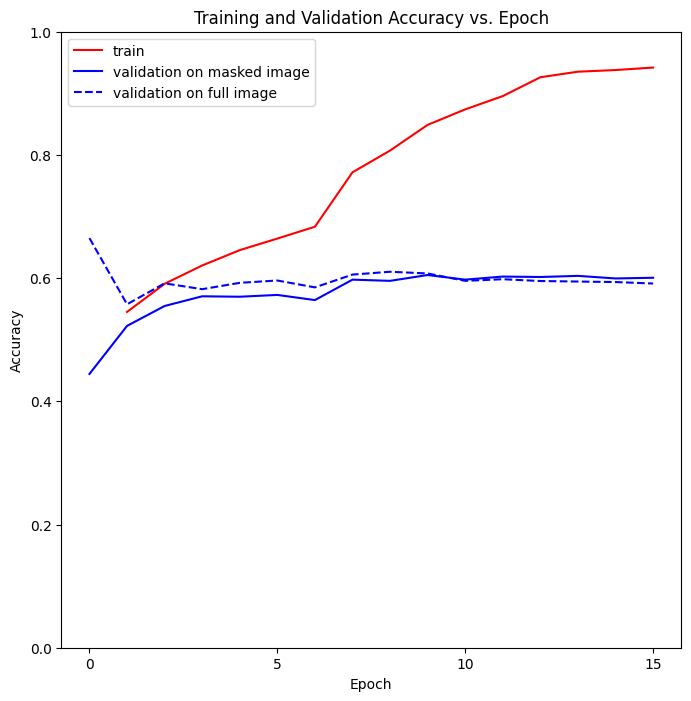

In [20]:
## make plots
val1_plot = [val1_avg_acc] ## on masked
val2_plot = [val2_avg_acc] ## on full
train_plot = tr_acc[:]
val1_plot.extend(val1_acc[:])
val2_plot.extend(val2_acc[:])
plt.figure(figsize=(8,8))
plt.plot(range(1, len(train_plot) + 1), train_plot, 'r', label="train")
plt.plot(range(len(val1_plot)), val1_plot, "b", label="validation on masked image")
plt.plot(range(len(val2_plot)), val2_plot, "b--", label="validation on full image")
plt.xticks(np.arange(0, max(len(train_plot) + 1, len(val1_plot), len(val2_plot)), 5.0))
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy vs. Epoch")
plt.ylim(0,1)
plt.show()